In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
train_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/train/train"
validation_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/validation/validation"
test_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test"

creating data generators

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Low_Frequency_Lines     447
Extremely_Loud          447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
None_of_the_Above        81
1400Ripples              81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

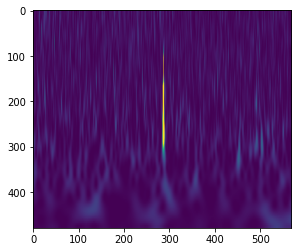

In [6]:
fullpath = train_dir + "/Blip/" + os.listdir(train_dir + "/Blip")[0]
img = mpimg.imread(fullpath)
plt.imshow(img)

getting the class names

In [7]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)
classes_list

['Blip',
 'Koi_Fish',
 'Low_Frequency_Burst',
 'Light_Modulation',
 'Power_Line',
 'Low_Frequency_Lines',
 'Extremely_Loud',
 'Scattered_Light',
 'Violin_Mode',
 'Scratchy',
 '1080Lines',
 'Whistle',
 'Helix',
 'Repeating_Blips',
 'No_Glitch',
 'Tomte',
 'None_of_the_Above',
 '1400Ripples',
 'Chirp',
 'Air_Compressor',
 'Wandering_Line',
 'Paired_Doves']

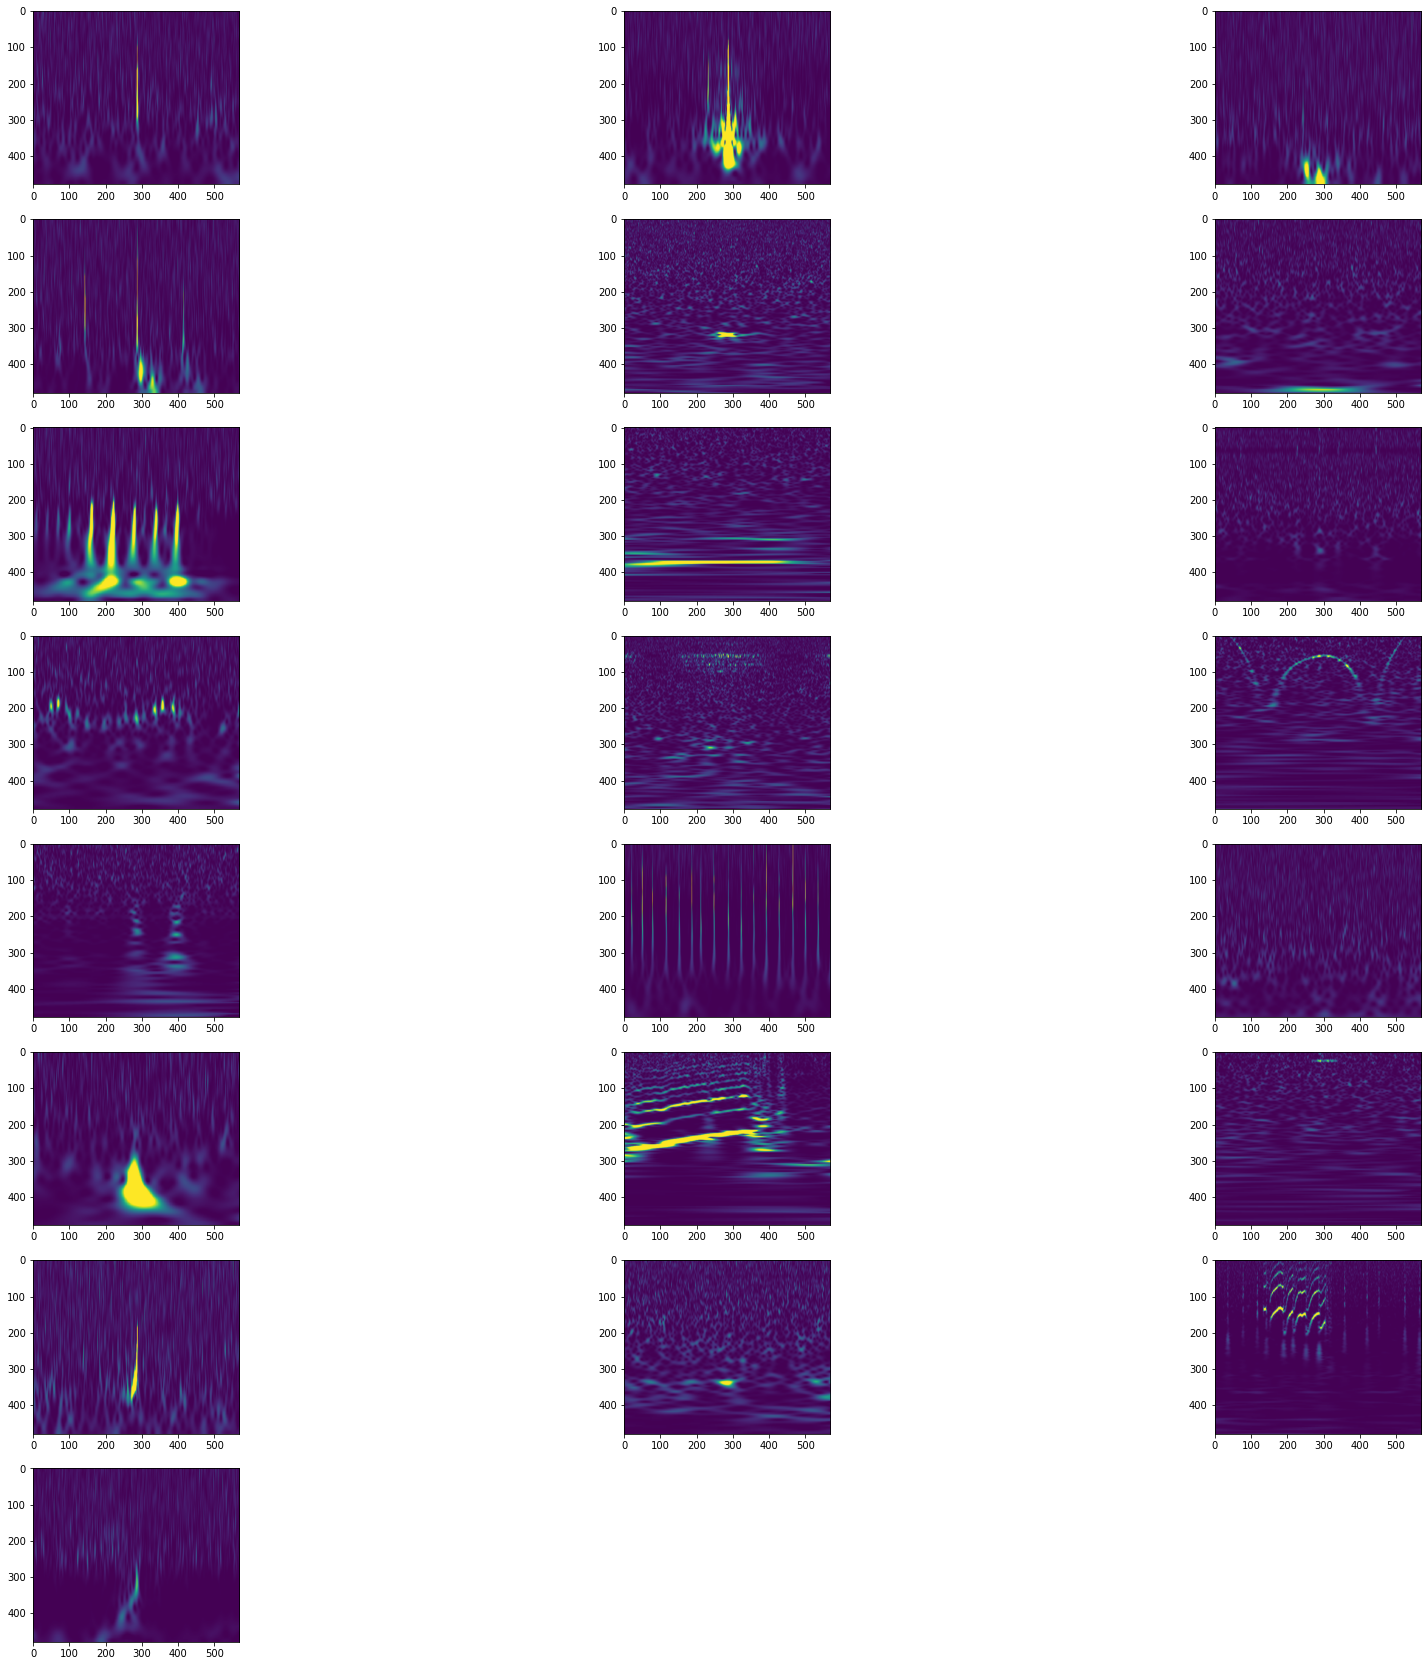

In [8]:
plt.figure(figsize=(30, 30))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + "/" + classes_list[i] + '/' + os.listdir(train_dir + "/" + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

In [9]:
training_batch_size = 10
validation_batch_size = 10
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [11]:
test_size = !find '/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


In [15]:
input_shape = (img_dim, img_dim, 3)

base_model = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape = input_shape
)
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

model.layers[0].trainable = False

model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.AUC(name='accuracy')]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
Total params: 87,990,334
Trainable params: 67,124,758
Non-trainable params: 20,865,576
___________________________________

In [16]:
training_step_size = 32
validation_step_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    mode = "max",
    patience = 6
)
history = model.fit(
    train_generator,
    steps_per_epoch = training_step_size,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_step_size,
    callbacks = [early_stopping],
    verbose = 1,
)

print("Training Done")

Epoch 1/100
32/32 [==============================] - 36s 987ms/step - loss: 24.7712 - accuracy: 0.7139 - val_loss: 12.2395 - val_accuracy: 0.7796
Epoch 2/100
32/32 [==============================] - 25s 779ms/step - loss: 6.5863 - accuracy: 0.8320 - val_loss: 8.2924 - val_accuracy: 0.7840
Epoch 3/100
32/32 [==============================] - 30s 913ms/step - loss: 2.7922 - accuracy: 0.8996 - val_loss: 2.5198 - val_accuracy: 0.9079
Epoch 4/100
32/32 [==============================] - 23s 690ms/step - loss: 3.1404 - accuracy: 0.9015 - val_loss: 1.7890 - val_accuracy: 0.9311
Epoch 5/100
32/32 [==============================] - 22s 684ms/step - loss: 1.4170 - accuracy: 0.9466 - val_loss: 1.8868 - val_accuracy: 0.9299
Epoch 6/100
32/32 [==============================] - 24s 766ms/step - loss: 1.3865 - accuracy: 0.9482 - val_loss: 1.6184 - val_accuracy: 0.9321
Epoch 7/100
32/32 [==============================] - 23s 706ms/step - loss: 1.6732 - accuracy: 0.9325 - val_loss: 1.3484 - val_accurac

In [17]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [18]:
# test_scores = model.evaluate(test_generator, steps = test_size, verbose = 1)

In [19]:

# print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

classes = classes_list
train_hist = history
test_gen = test_generator

y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)

# Evaluate the results:
test_loss, test_metric = model.evaluate(test_gen,verbose = False)
results       = test_metric*100 
results_title ="\n Model Accuracy on Test Data:{}%".format(results)
print(results_title.format(results))
print(len(results_title) * "-")
    
# print classification report
print(classification_report(y_actual, y_pred, target_names=classes))


 Model Accuracy on Test Data:96.6361939907074%
-----------------------------------------------
                     precision    recall  f1-score   support

               Blip       0.85      0.95      0.90      1092
           Koi_Fish       0.73      0.88      0.80       408
Low_Frequency_Burst       0.74      0.82      0.78       360
   Light_Modulation       0.82      0.68      0.74       312
         Power_Line       0.72      0.96      0.82       272
Low_Frequency_Lines       0.60      0.80      0.69       264
     Extremely_Loud       0.73      0.97      0.83       256
    Scattered_Light       0.91      0.84      0.87       268
        Violin_Mode       0.89      0.52      0.66       256
           Scratchy       0.91      0.72      0.81       200
          1080Lines       0.54      0.63      0.58       200
            Whistle       0.93      0.85      0.89       180
              Helix       0.77      0.79      0.78       168
    Repeating_Blips       0.89      0.66      0.7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# extract data from training history for plotting
history_dict    = train_hist.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values      = history_dict['accuracy']
val_accuracy_values  = history_dict['val_accuracy']
epochs          = range(1, len(history_dict['accuracy']) + 1)

# get the min loss and max accuracy for plotting
max_acc = np.max(val_accuracy_values)
min_loss = np.min(val_loss_values)
    

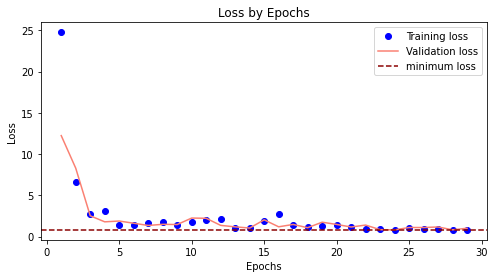

In [22]:
# create plots
plt.subplots(figsize=(8,4))

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
plt.title('Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkred', linestyle='--', label = "minimum loss")
plt.legend()

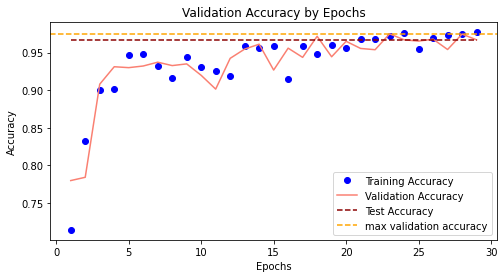

In [23]:
plt.subplots(figsize=(8,4))
plt.plot(epochs, acc_values, 'bo',label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'salmon', label = 'Validation Accuracy')
plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test Accuracy')
plt.title('Validation Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axhline(y=max_acc,color='orange', linestyle='--', label = "max validation accuracy")
plt.legend()

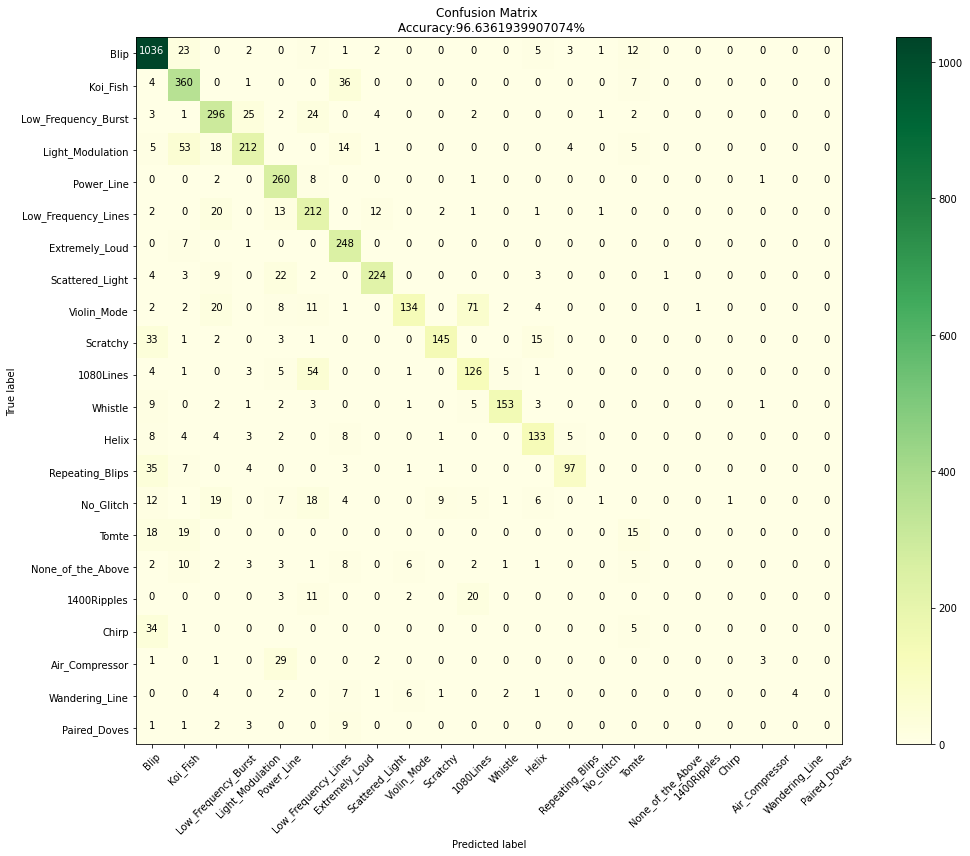

In [24]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlGn)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

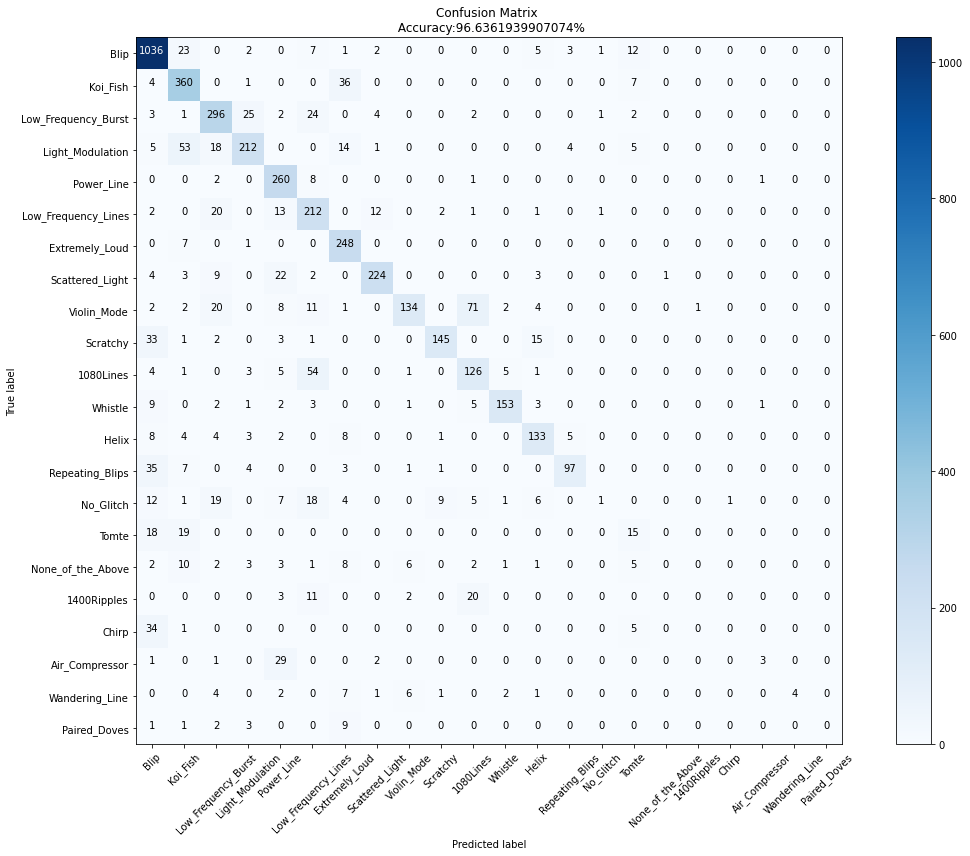

In [25]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

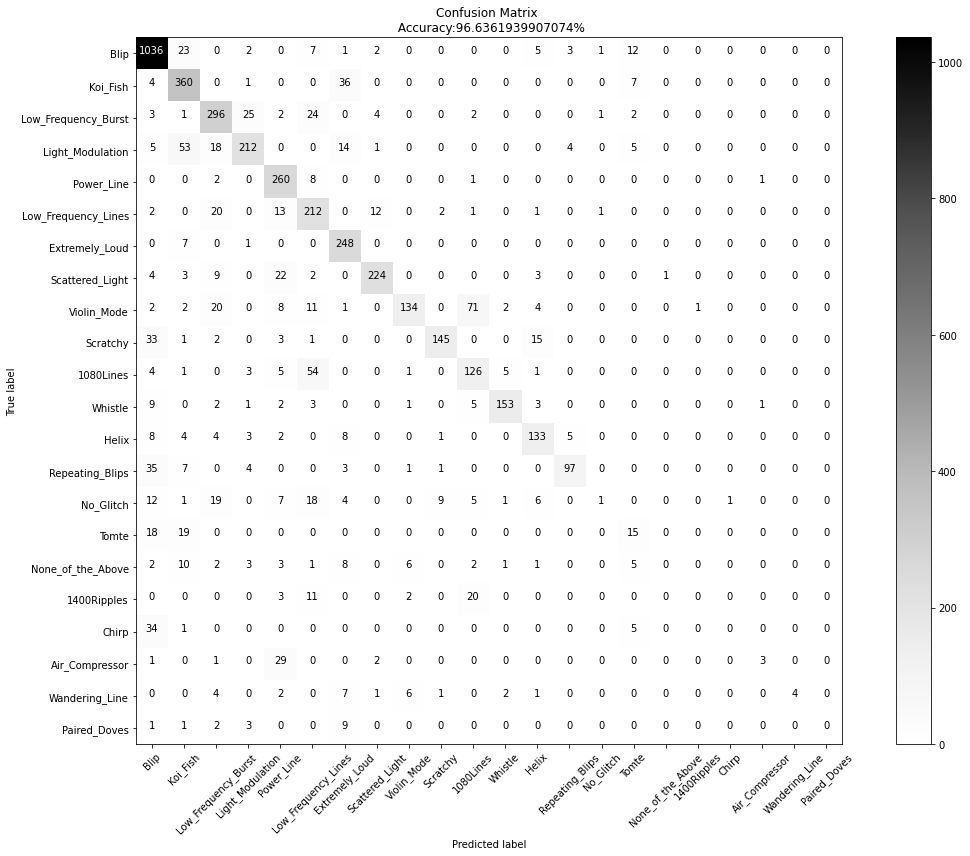

In [26]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

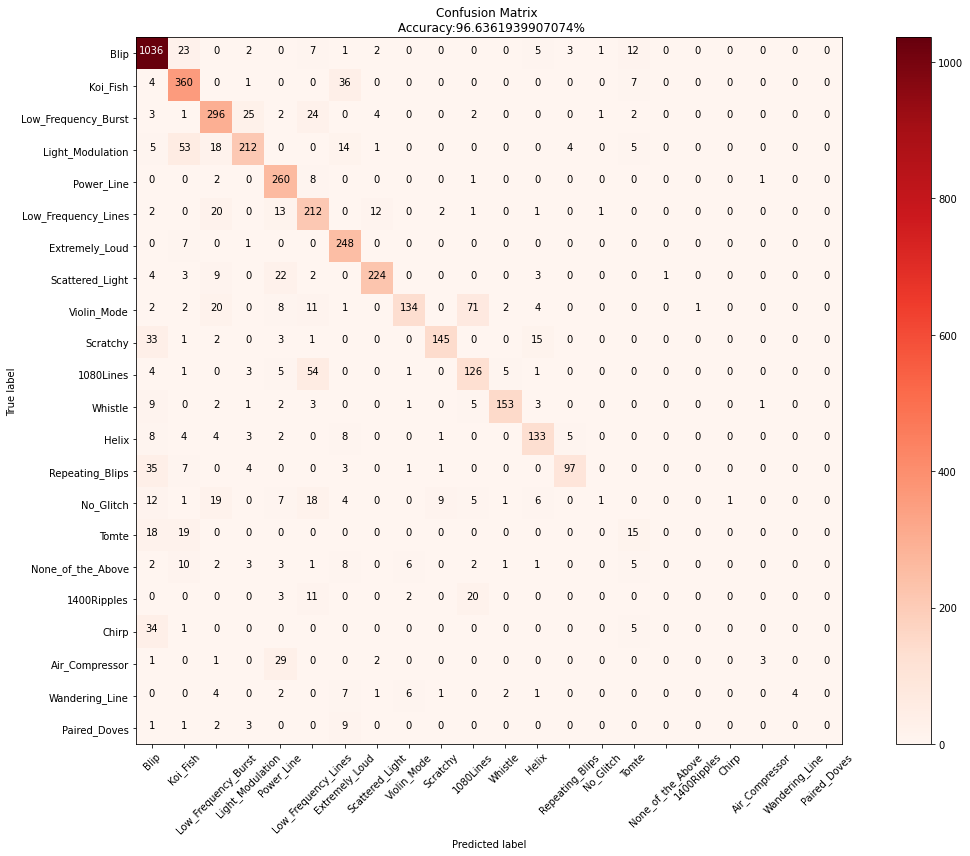

In [27]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

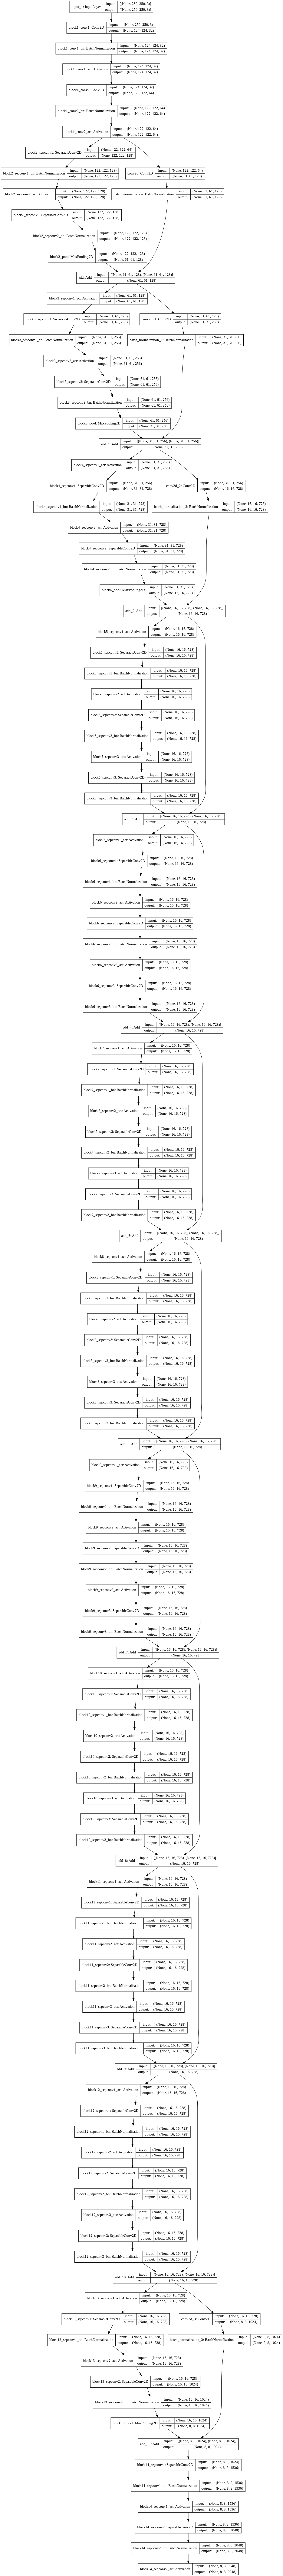

In [28]:
from keras.utils.vis_utils import plot_model

plot_model(base_model, to_file="InceptionResNetV2_Base_Model.png", show_shapes=True, show_layer_names=True)